# Brief

Mobile carrier Megaline has found out that many of their subscribers use legacy plans. They want to develop a model that would analyze subscribers' behavior and recommend one of Megaline's newer plans: Smart or Ultra. 

We have access to behavior data about subscribers who have already switched to the new plans. The data has been largely preprocessed. 

# Data

Every observation in the dataset contains monthly behavior information about one user. The information given is as follows:

- `сalls`: number of calls,
- `minutes`: total call duration in minutes,
- `messages`: number of text messages,
- `mb_used`: Internet traffic used in MB,
- `is_ultra`: plan for the current month (Ultra - 1, Smart - 0).

# Task

Develop a model with the highest possible accuracy. In this project, the threshold for accuracy is 0.75. Check the accuracy using the test dataset.  

**Libraries**

Common

In [140]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Sklearn

In [141]:
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

**Data**

In [142]:
try:
    df = pd.read_csv('/Users/dani/Data Science/TripleTen Projects/Project Data/Intro to ML/users_behavior.csv')
except:
    print('Double check your file path')

Dtypes

In [143]:
df.info() # no perceived null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [144]:
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [145]:
print('Table Sample:')
display(df.sample(10))
print('')
print('Descriptive Statistics:') # will need to take into account 'mb_used' due to difference in # magnitude vs the other features
df.describe()

Table Sample:


,calls,minutes,messages,mb_used,is_ultra
561,46.0,333.24,6.0,20286.28,0
1447,51.0,454.46,0.0,22857.34,0
437,71.0,501.94,33.0,16853.73,0
1360,128.0,1012.44,72.0,20324.19,1
2505,74.0,463.12,44.0,14037.90,0
1127,71.0,457.93,51.0,16559.23,0
2149,41.0,239.53,53.0,25004.15,1
3044,92.0,703.35,81.0,29652.09,1
138,92.0,627.52,52.0,39597.61,1
1576,60.0,488.33,3.0,14134.37,0



Descriptive Statistics:


,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


[Text(0.5, 1.0, 'Feature Correlation')]

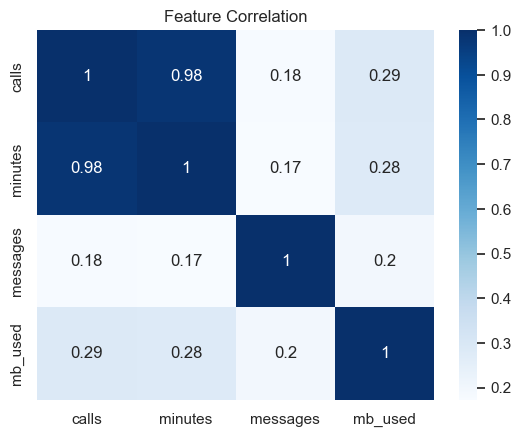

In [146]:
sns.heatmap(df.drop('is_ultra', axis=1).corr(), cmap='Blues', annot=True).set(title='Feature Correlation')

Target

In [147]:
df.is_ultra.value_counts()

is_ultra
0    2229
1     985
Name: count, dtype: int64

/var/folders/wc/6x35sr293njgq8g1xgc9fzlm0000gn/T/ipykernel_23571/962621062.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Smart', 'Ultra'])


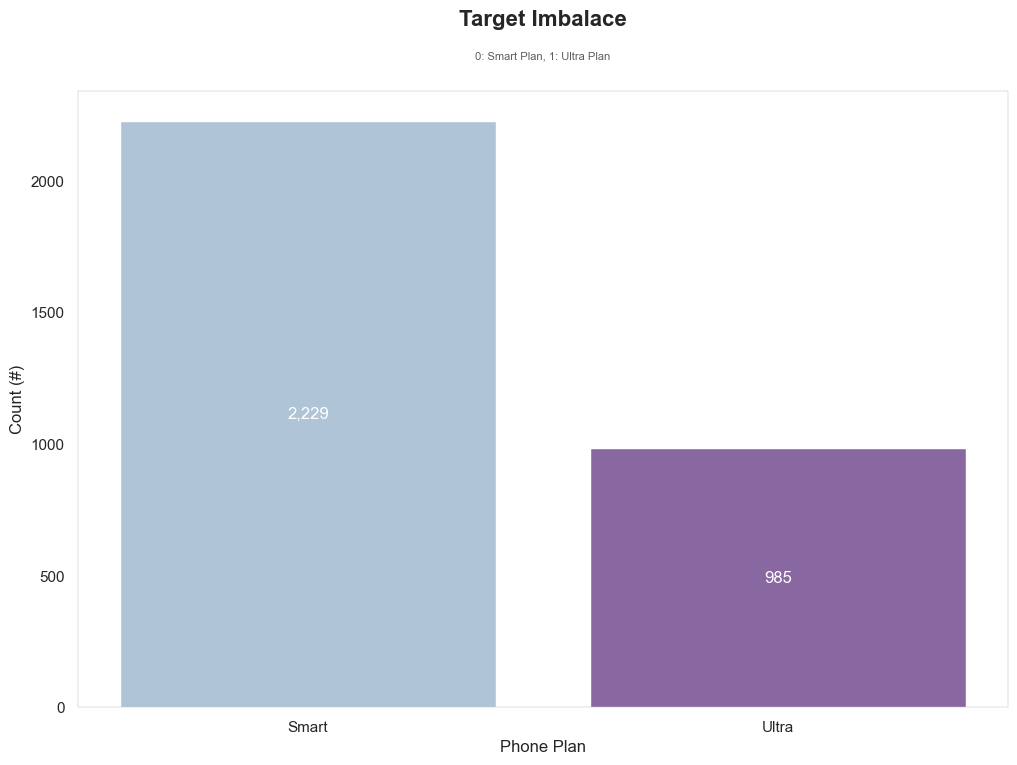

In [148]:
# confirming imbalance
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
fig, ax = plt.subplots(figsize=(12, 8))

sns.countplot(data=df, x='is_ultra', palette="BuPu", ax=ax, hue='is_ultra', legend=None)
ax.set(xlabel="Phone Plan", ylabel='Count (#)')
for c in ax.containers:
    labels = [f'{round((v.get_height())):,}' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color='white')

ax.relim()  # the plot limits need to be updated with the moved bars
ax.autoscale()
ax.set_xticklabels(['Smart', 'Ultra'])
ax.text(x=0.5, y=1.1, s='Target Imbalace', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s='0: Smart Plan, 1: Ultra Plan', fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)


plt.show()

**Features**

Boxplots

<Axes: >

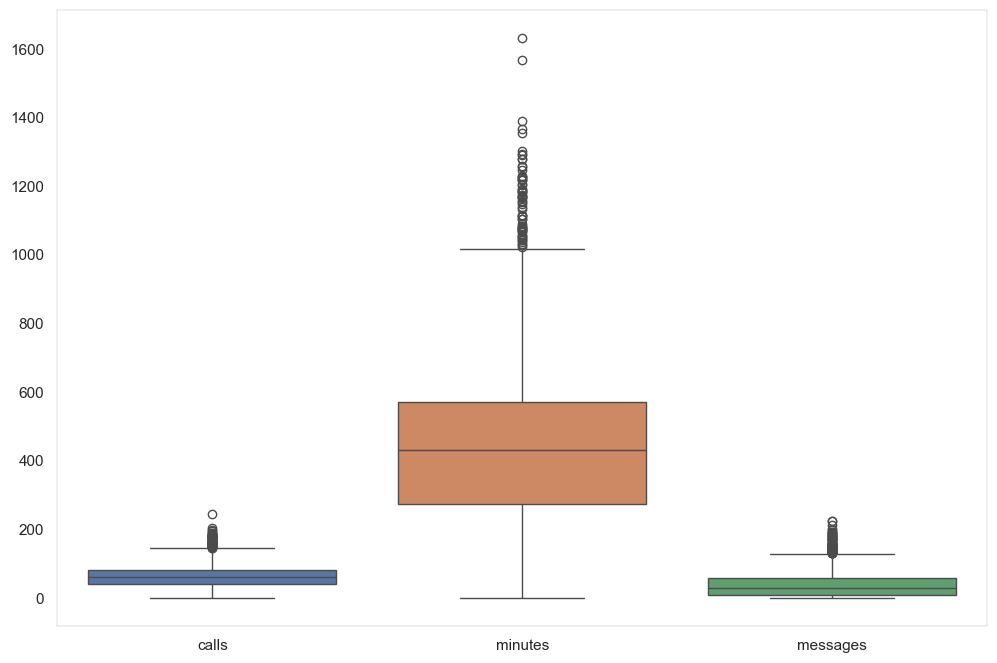

In [149]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df[['calls', 'minutes', 'messages']])

<Axes: ylabel='mb_used'>

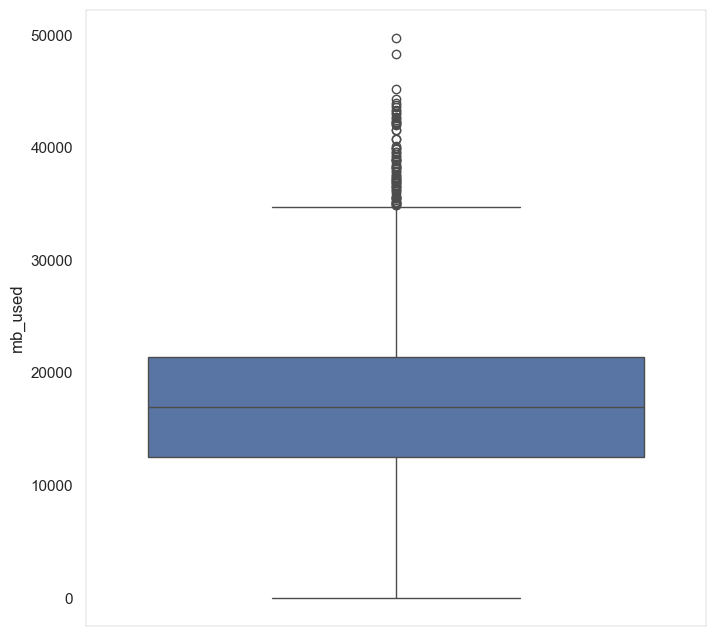

In [150]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
fig, ax = plt.subplots(figsize=(8, 8))
sns.boxplot(data=df.mb_used)

Thresholds

In [151]:
# 75th percentile
seventy_fifth = df["mb_used"].quantile(0.75)
# 25th percentile
twenty_fifth = df["mb_used"].quantile(0.25)
# iqr
mb_iqr = seventy_fifth - twenty_fifth

Outliers

In [152]:
# upper threshold
upper = seventy_fifth + (1.5 * mb_iqr)

# lower threshold
lower = twenty_fifth - (1.5 * mb_iqr)

print(upper, lower)

34823.89624999997 -907.2937499999753


Subset

In [153]:
df[(df["mb_used"] < lower) | (df["mb_used"] > upper)] \
    [["calls","minutes","messages","mb_used"]]

,calls,minutes,messages,mb_used
55,13.0,106.03,16.0,37328.45
104,84.0,566.42,0.0,39307.06
138,92.0,627.52,52.0,39597.61
190,109.0,784.55,0.0,38102.20
192,123.0,810.67,12.0,36684.49
...,...,...,...,...
2945,109.0,699.50,0.0,40736.65
2980,93.0,672.10,29.0,36991.59
3125,111.0,782.50,51.0,38798.13
3144,110.0,868.26,89.0,37383.20


Dropping outliers

In [154]:
no_outliers = df[(df["mb_used"] > lower) & (df["mb_used"] < upper)]

display(no_outliers["mb_used"].describe())

count     3137.000000
mean     16670.149315
std       6812.338038
min          0.000000
25%      12403.260000
50%      16784.340000
75%      21046.270000
max      34709.120000
Name: mb_used, dtype: float64

Histograms

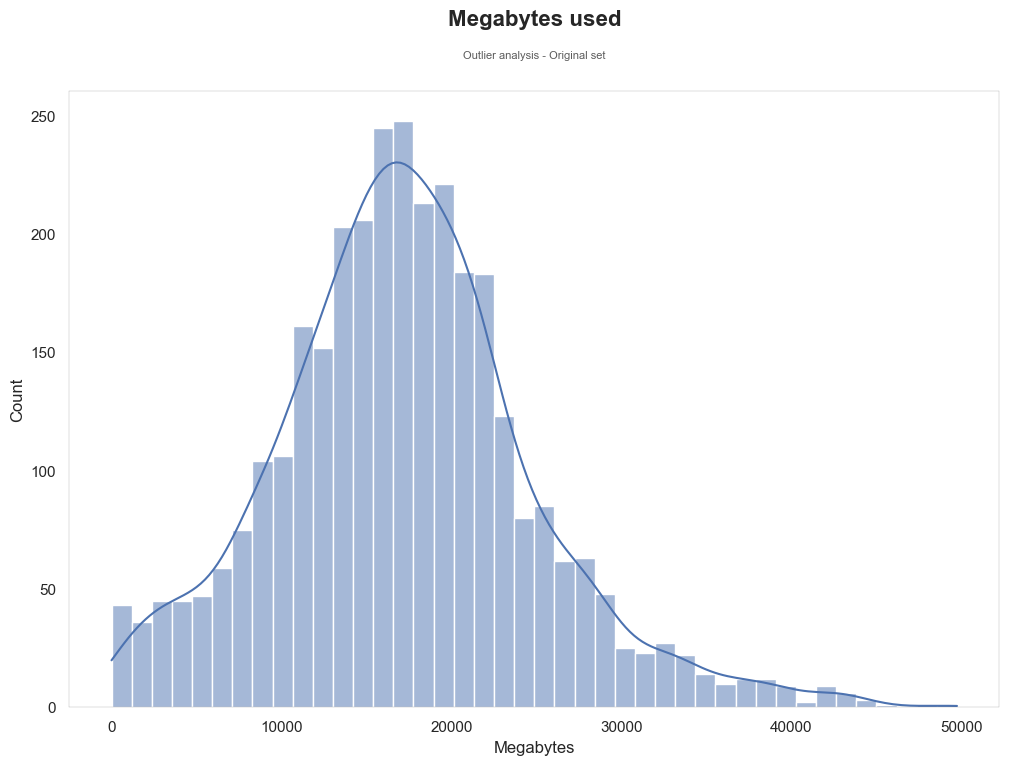

In [155]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
fig, ax = plt.subplots(figsize=(12, 8))


sns.histplot(data=df["mb_used"], kde=True, bins='auto', ax=ax
             #hue='calls', palette="BuPu", ax=ax, legend=None
             )
ax.set(xlabel="Megabytes")
ax.text(x=0.5, y=1.1, s='Megabytes used', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s='Outlier analysis - Original set', fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
plt.show()

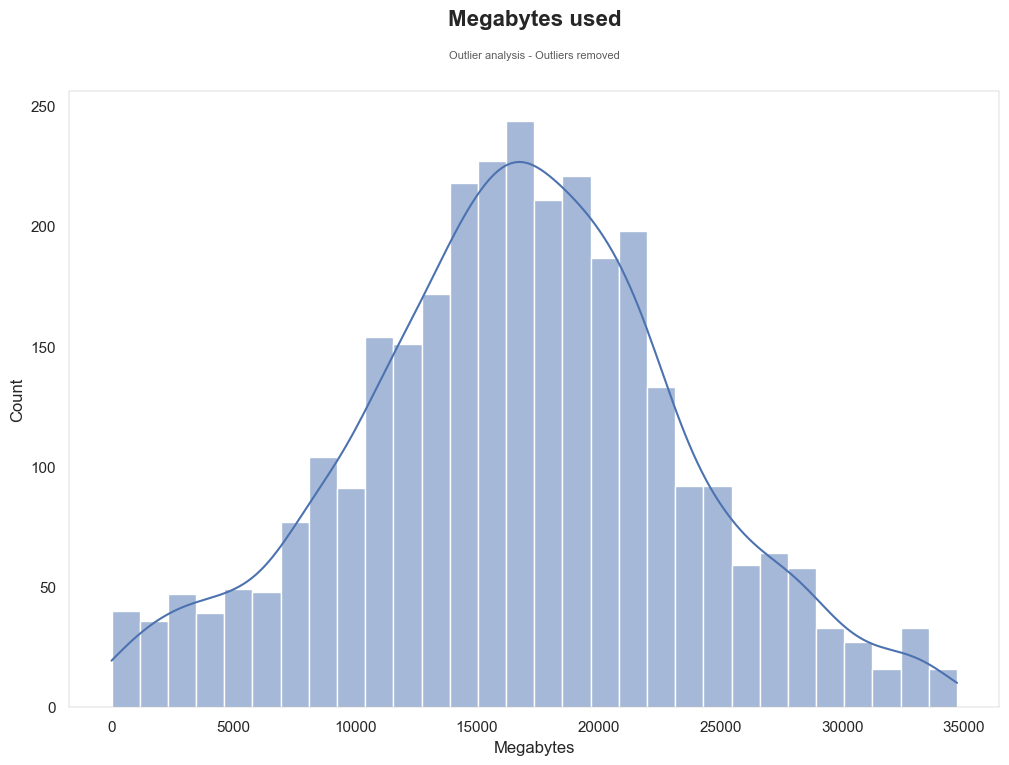

In [156]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(data=no_outliers["mb_used"], kde=True, bins='auto', ax=ax
             #hue='mb_used', palette="BuPu", ax=ax, legend=None
             )
ax.set(xlabel="Megabytes")
ax.text(x=0.5, y=1.1, s='Megabytes used', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s='Outlier analysis - Outliers removed', fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

plt.show()



Distribution plots

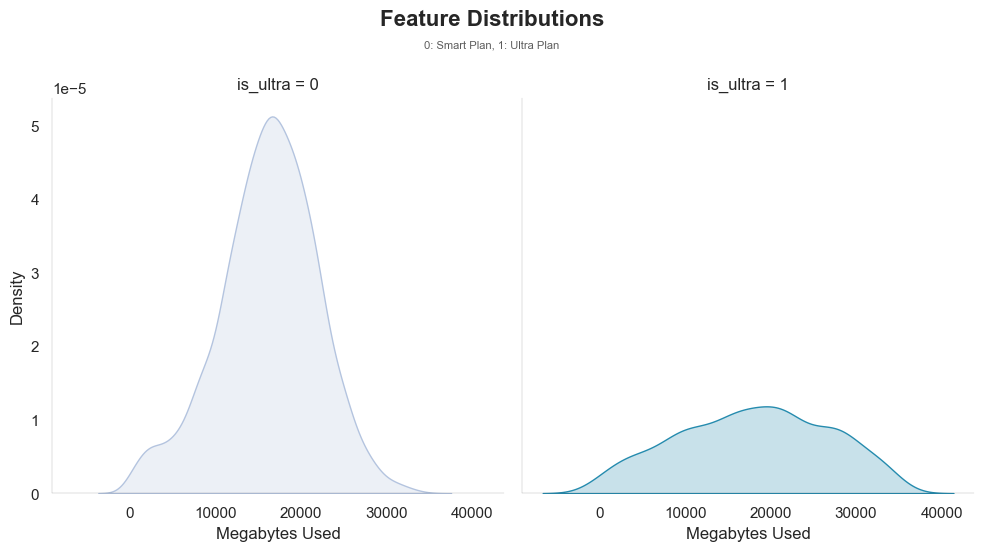

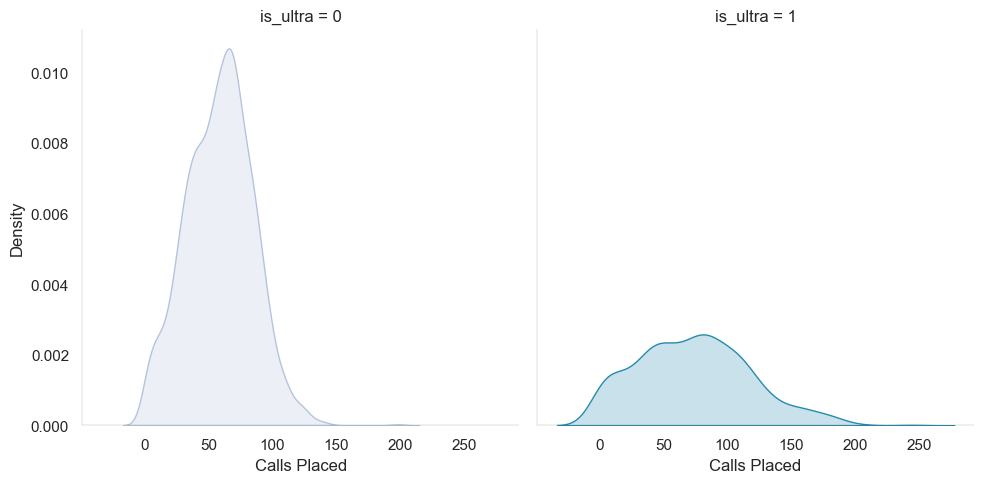

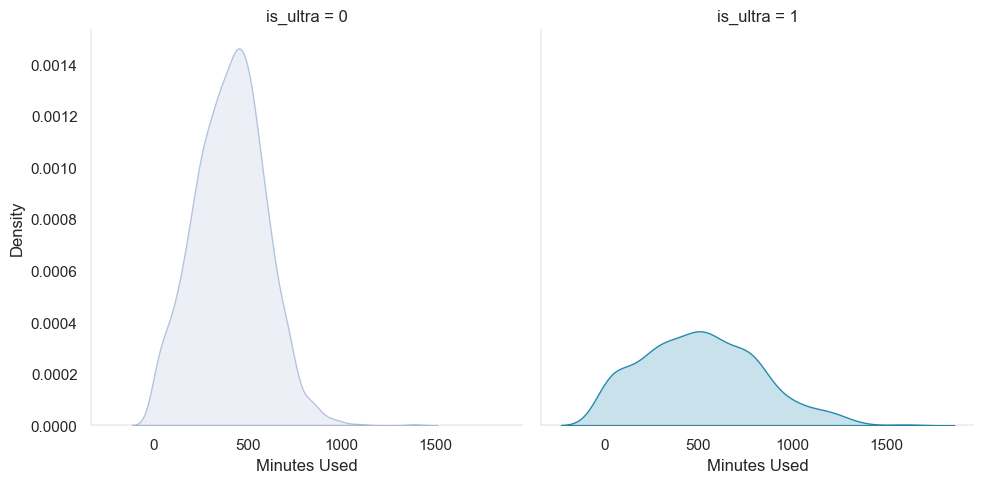

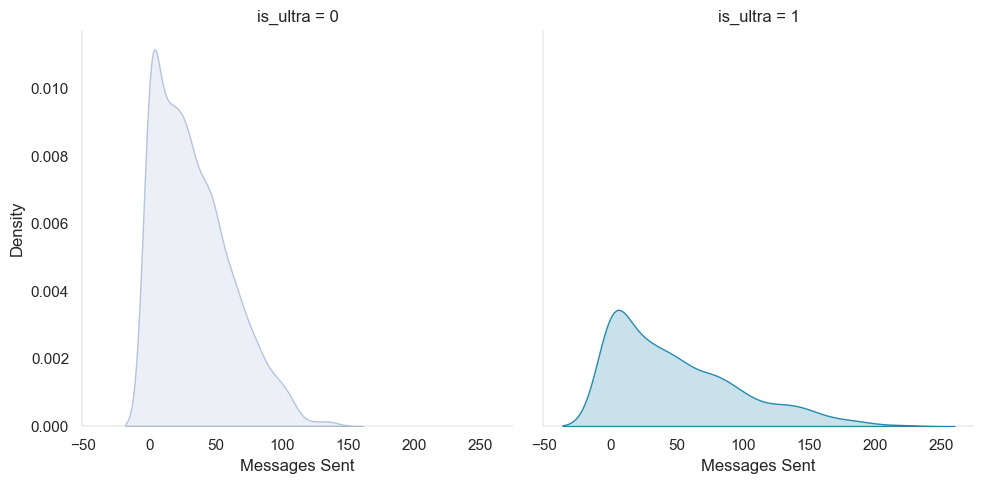

In [157]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
fig, ax = plt.subplots(figsize=(12, 10), sharex=False, sharey=False)
plt.close()
g = sns.displot(data=no_outliers, x="mb_used", col="is_ultra", hue='is_ultra', kind="kde", legend=None, fill=True, palette='PuBuGn').set(xlabel='Megabytes Used')
g.fig.suptitle('Feature Distributions', x=0.5, y=1.1, ha='center', va='top', fontsize=16, weight='bold')
g.fig.text(x=0.5, y=1.02, s='0: Smart Plan, 1: Ultra Plan', fontsize=8, alpha=0.75, ha='center', va='bottom')

sns.displot(data=df, x="calls", col="is_ultra", hue='is_ultra', kind="kde", legend=None, fill=True, palette='PuBuGn').set(xlabel='Calls Placed')
sns.displot(data=df, x="minutes", col="is_ultra", hue='is_ultra', kind="kde", legend=None, fill=True, palette='PuBuGn').set(xlabel='Minutes Used')
sns.displot(data=df, x="messages", col="is_ultra", hue='is_ultra', kind="kde", legend=None, fill=True, palette='PuBuGn').set(xlabel='Messages Sent')

plt.tight_layout()
plt.show()

**Models**

- Not utilizing hyperparameter tuning if the score above target threshold is achieved
    - However, will deploy tuning after final model is selected for further metric analysis

Features and Target

In [158]:
df_clean = no_outliers # removal of outliers under the mb_used feature

X = df_clean.drop(['is_ultra'], axis=1) # extracting features
y = df_clean['is_ultra'] # extracting target

Reproducibility

In [159]:
seed = 12345

RepeatedStratifiedKFold

In [160]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)

In [161]:
# our original analysis involved splitting the data into training, validation and test sets, deploying only training and test sets here for comparison
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=seed)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# print(np.mean(features), np.std(features))
# print(np.mean(X_train_scaled), np.std(X_test_scaled))

print(f'Proportion of Target in the Training set:\n{y_train.value_counts() / len(X_train)}\n\n'+
      f'Proportion of Target in the Test set:\n{y_test.value_counts() / len(X_test)}')


Proportion of Target in the Training set:
is_ultra
0    0.707055
1    0.292945
Name: count, dtype: float64

Proportion of Target in the Test set:
is_ultra
0    0.713376
1    0.286624
Name: count, dtype: float64


Voting Classifier

In [162]:
lr = LogisticRegression(random_state=seed)
knn = KNN()
dt = DecisionTreeClassifier(random_state=seed)
rf = RandomForestClassifier(random_state=seed)

classifiers = [('Logistic Regression', lr), ('K Nearest Neighbors', knn),
              ('Classification Tree', dt), ('Random Forest', rf),]

In [163]:
for clf_name, clf in classifiers:
    # fit the training set
    clf.fit(X_train_scaled, y_train)

    # label prediction
    y_pred = clf.predict(X_test_scaled)

    # evaluations
    cv = cross_val_score(clf, X_train_scaled, y_train, scoring='accuracy', cv=rskf)
    print('{:s} Average Cross-Val Score w/Accuracy scoring: {:.3f}'.format(clf_name, cv.mean()))

Logistic Regression Average Cross-Val Score w/Accuracy scoring: 0.743
K Nearest Neighbors Average Cross-Val Score w/Accuracy scoring: 0.777
Classification Tree Average Cross-Val Score w/Accuracy scoring: 0.721
Random Forest Average Cross-Val Score w/Accuracy scoring: 0.801


In [164]:
vc = VotingClassifier(estimators=classifiers)

# fit and predict
vc.fit(X_train_scaled, y_train)
y_pred = vc.predict(X_test_scaled)

# evaluation
cv = cross_val_score(vc, X_train_scaled, y_train, scoring='accuracy', cv=rskf)
print('Average Cross-Val Score w/Accuracy scoring: {:.3f}'.format(cv.mean()))

Average Cross-Val Score w/Accuracy scoring: 0.786


Bagging Classifier

In [165]:
bc = BaggingClassifier(estimator=dt)

bc.fit(X_train_scaled, y_train)

y_pred = bc.predict(X_test_scaled)

# evaluation
cv = cross_val_score(bc, X_train_scaled, y_train, scoring='accuracy', cv=rskf)

print('Average Cross-Val Score w/Accuracy scoring: {:.3f}'.format(cv.mean()))

Average Cross-Val Score w/Accuracy scoring: 0.789


AdaBoost

In [166]:
adb_clf = AdaBoostClassifier(estimator=rf, algorithm='SAMME')

adb_clf.fit(X_train_scaled, y_train)

y_pred = adb_clf.predict(X_test_scaled)

# evaluation
cv = cross_val_score(adb_clf, X_train_scaled, y_train, scoring='accuracy', cv=rskf)

print('Average Cross-Val Score w/Accuracy scoring: {:.3f}'.format(cv.mean()))

Average Cross-Val Score w/Accuracy scoring: 0.801


Stochastic Gradient Boosting

In [167]:
gbt = GradientBoostingClassifier(random_state=seed)

gbt.fit(X_train_scaled, y_train)

y_pred_sgbt = gbt.predict(X_test_scaled)

# evaluation
cv = cross_val_score(gbt, X_train_scaled, y_train, scoring='accuracy', cv=rskf)

print('Average Cross-Val Score w/Accuracy scoring: {:.3f}'.format(cv.mean()))

Average Cross-Val Score w/Accuracy scoring: 0.803


**Final Evaluation on the Test set**

Top Features:
    Feature  Importance
0     calls    0.178439
2  messages    0.217127
1   minutes    0.261945
3   mb_used    0.342490


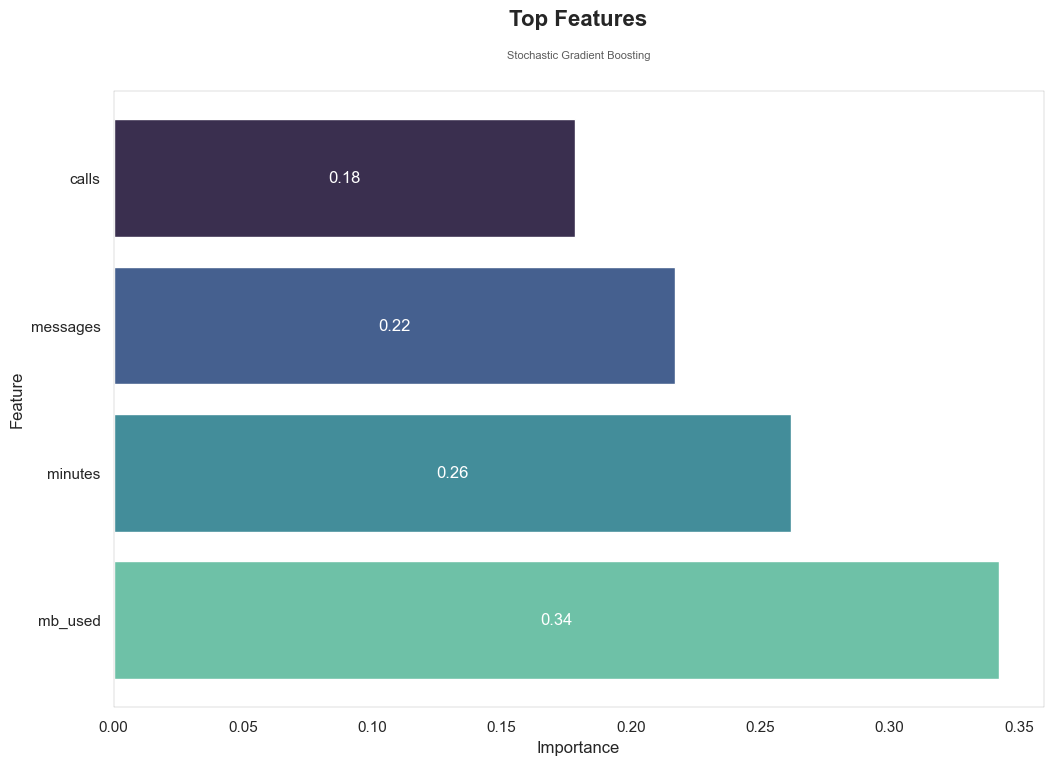

In [168]:
feature_importances = gbt.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance')

top_features = feature_importance_df.head()
print("Top Features:")
print(top_features)

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data = top_features,
            y = 'Feature', x = 'Importance',
              palette="mako", hue='Feature',
              ax=ax)


for c in ax.containers:
    labels = [f'{( round(v.get_width(),2) )}' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color='white')

ax.relim()  # the plot limits need to be updated with the moved bars
ax.autoscale()
ax.text(x=0.5, y=1.1, s='Top Features', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s='Stochastic Gradient Boosting', fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

plt.xlabel('Importance')
plt.show()

In [169]:
print(classification_report(y_test, y_pred_sgbt))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       448
           1       0.78      0.52      0.62       180

    accuracy                           0.82       628
   macro avg       0.81      0.73      0.75       628
weighted avg       0.82      0.82      0.81       628


Model selection: Gradient Boosting Classifier

In [171]:
# test set evaluation
print('Final Gradient Boosting Accuracy Score on Test set:')
final_model_accuracy = accuracy_score(y_test,y_pred_sgbt)
#result
print(round((final_model_accuracy * 100), 2),'%') 

Final Gradient Boosting Accuracy Score on Test set:
82.01 %


Hyperparameter tuning

In [172]:
gbt_params = {
    'n_estimators': [100, 150, 300],
    'max_depth': [2, 4, 6],
    'min_samples_leaf': [0.03, 0.05, 1],
    'subsample': [0.4, 0.8]
}

grid_sgbt = GridSearchCV(gbt, gbt_params, cv=rskf, scoring='accuracy', n_jobs=-1, verbose=1)
grid_sgbt.fit(X_train_scaled, y_train)

best_model = grid_sgbt.best_estimator_
grid_y_pred = best_model.predict(X_test_scaled)

accuracy_hyper_sgbt = accuracy_score(y_test,grid_y_pred)
print('Final Tuned Gradient Boosting Accuracy Score: {:.3f}'.format(accuracy_hyper_sgbt))

Fitting 50 folds for each of 54 candidates, totalling 2700 fits
Final Tuned Gradient Boosting Accuracy Score: 0.815


In [173]:
print(classification_report(y_test, grid_y_pred))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       448
           1       0.75      0.53      0.62       180

    accuracy                           0.82       628
   macro avg       0.79      0.73      0.75       628
weighted avg       0.81      0.82      0.80       628


# Conclusions

Our dataset was mostly preprocessed beforehand but doing a quick dive into the metrics, we found some possible modeling issues with outliers and the magnitude of some of the values in one specific feature.


- We implemented a quick fix to start with a simple removal of major outliers with the aim to improve the learning and scores of our classifier models. Feature scaling was also implemented to create scaled model inputs but the impact wasn't as acute. Most feature values were bound to similar ranges with the exception of one (the one with the outliers). 

- There was imbalance in the data, which we noticed early in the process. RepeatedStratifiedKFold was deployed to ensure that the percentages of each class in the data would be very close to each other within the individual folds. Sampling techniques like SMOTE/SMOTEBoost/EasyEnsemble or other metrics like F1-Score were not used in this project given we achieved the target accuracy score but were considered if the output was not up to par.

- Hyperparameter tuning was only implemented after we finalized our model selection to see if there were any further improvements while utilizing tools like GridSearchCV. Tuning did not yield improvements and we would have to start making compromises as we expand said search (e.g. modeling speed loss).

- Lastly and as expected, we noticed much lower scores throughout (on our test set) if outliers were left as-is in our dataset. This was equivalent to a drop in acccuracy of 487bps (77.14% vs 82.01%).

The recommendation is for our client to leverage the Stochastic Gradient Boosting method and think about further compromises to be made further down the road (e.g. trade-offs with increased complexity). With that said, incorporating more data would possibly prove to be beneficial (taking heightened consideration for sampling or other metrics).